In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.data.gamma.structural_pubmed import load_dataset, get_train_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency
from src.train.structural_omega.gcn import StructuralOmegaGCNCosSim

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logs_filename = 'logs/omega_function/pubmed/05-1-structural_gcn_cossim_gamma_function.log'

In [4]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename=logs_filename
)

In [5]:
torch.cuda.is_available()

True

In [6]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [7]:
dataset = load_dataset()

In [8]:
data, edges_train, edges_val, edges_test = get_train_val_test_edges(dataset, device=device)

In [9]:
data = prepare_adjencency(data)

## Training

In [10]:
for run in range(10):
    for n_layers_gcn in range(1, 4):
        omega = StructuralOmegaGCNCosSim(
            device,
            dataset='pubmed',
            in_channels=data.x.shape[1],
            n_layers_gcn=n_layers_gcn,
            run=run)
        torch.cuda.empty_cache()
        omega.train(edges_train,
                    edges_val,
                    edges_test,
                    data.x,
                    data.y.reshape(-1, 1),
                    data.adj_t)

## Results

### For a Layer Number

In [11]:
n_layers_gcn = 1

In [12]:
metrics = StructuralOmegaGCNCosSim.read_metrics(
    dataset='pubmed',
    n_layers_gcn=n_layers_gcn)
print(metrics.shape)
metrics.head()

(410, 8)


,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,0,0,0.545491,0.530672,0.535690,0.519327,0.512049,0.530255
1,0,50,0.462628,0.447561,0.456959,0.745810,0.734754,0.709717
2,0,100,0.406763,0.399643,0.421500,0.807735,0.777604,0.760511
3,0,150,0.368945,0.383218,0.403133,0.858656,0.800399,0.795359
4,0,200,0.343154,0.374988,0.392910,0.884982,0.805424,0.816101


### Sumarize metrics per epoch

In [13]:
metrics_cols = metrics.columns[2:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test'],
      dtype='object')

In [14]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [15]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,0.544725,0.001382,0.529272,0.001813,0.535939,0.001985,0.524627,0.005012,0.523446,0.009110,0.524177,0.010672
50,0.464041,0.002965,0.448951,0.003175,0.457489,0.001599,0.744370,0.005425,0.731263,0.010711,0.708650,0.005575
100,0.407488,0.002222,0.401023,0.002110,0.421641,0.001179,0.807325,0.004350,0.777803,0.004378,0.761406,0.004814
150,0.368112,0.001794,0.383915,0.001100,0.402105,0.000886,0.861218,0.003977,0.803838,0.003656,0.799014,0.003546
200,0.341615,0.001312,0.376492,0.001272,0.391934,0.000907,0.885245,0.002052,0.806216,0.002528,0.816626,0.002174


In [16]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
650,0.250192,0.000971,0.365411,0.001963,0.362609,0.001025,0.937406,0.000535,0.820649,0.001774,0.838674,0.000909
750,0.238502,0.000959,0.365586,0.001757,0.362929,0.000787,0.943451,0.000472,0.820031,0.001104,0.838292,0.000576
600,0.257475,0.002347,0.366179,0.002926,0.363168,0.001140,0.933800,0.001051,0.819674,0.002403,0.838423,0.001282
700,0.244108,0.000738,0.367199,0.001969,0.362478,0.000583,0.940332,0.000442,0.819152,0.001434,0.838035,0.000621
550,0.263604,0.001117,0.366880,0.002268,0.363595,0.000657,0.930178,0.000852,0.819076,0.001834,0.838345,0.001413


/tmp/ipykernel_1136222/2882194406.py:8: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_1136222/2882194406.py:9: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_1136222/2882194406.py:56: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future b

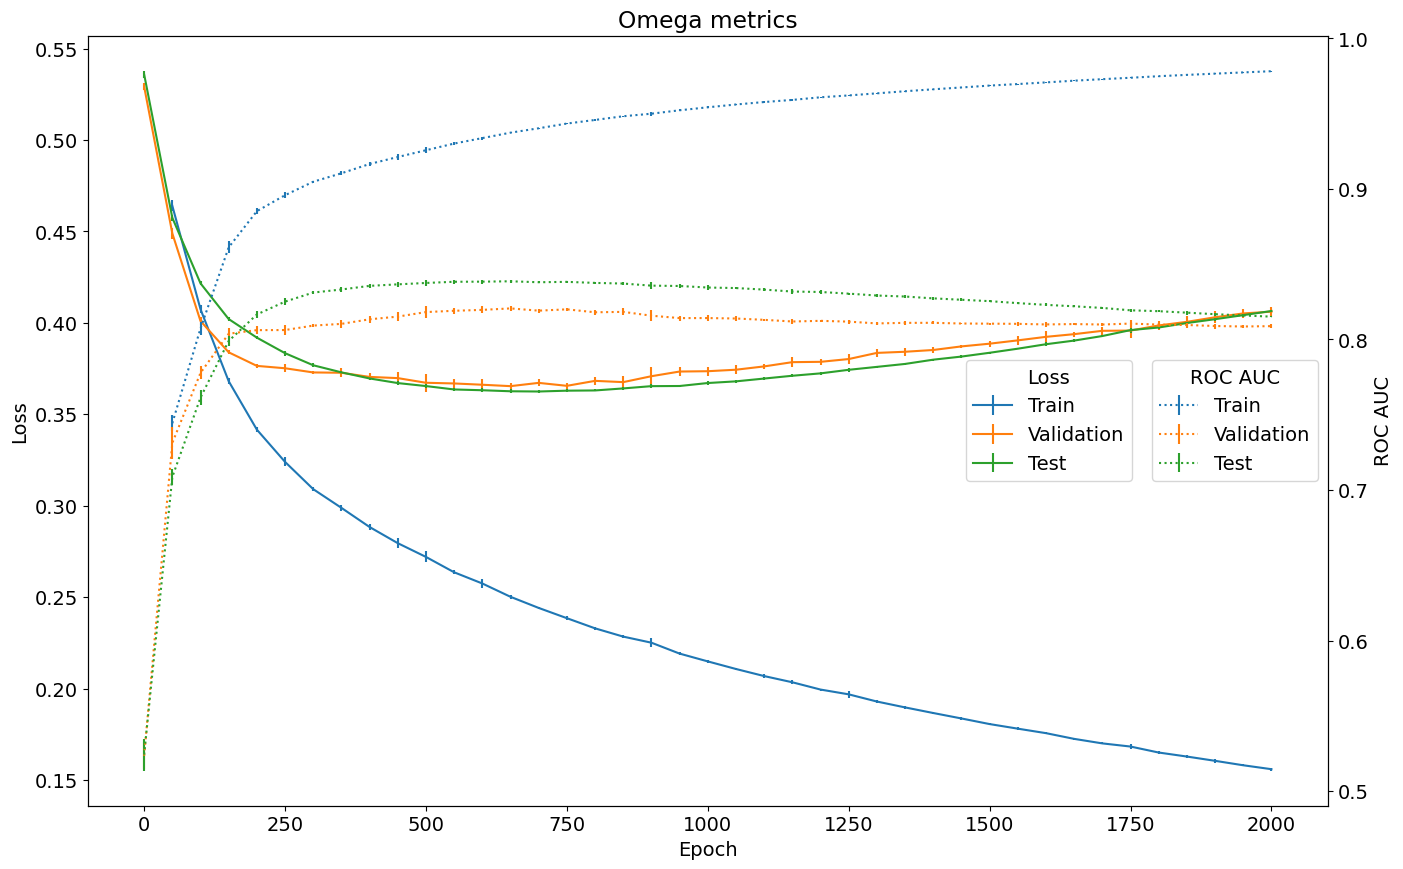

In [21]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Omega metrics')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

# ax1.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['loss_train_mean'][1:],
#     # yerr=epoch_metrics['loss_train_std'][1:],
#     ls='-',
#     label='Train')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_val_mean'],
#     # yerr=epoch_metrics['loss_val_std'],
#     ls='-',
#     label='Validation')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_test_mean'],
#     # yerr=epoch_metrics['loss_test_std'],
#     ls='-',
#     label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

# ax2.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['auc_train_mean'][1:],
#     # yerr=epoch_metrics['auc_train_std'][1:],
#     ls=':',
#     label='Train')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_val_mean'],
#     # yerr=epoch_metrics['auc_val_std'],
#     ls=':',
#     label='Validation')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_test_mean'],
#     # yerr=epoch_metrics['auc_test_std'],
#     ls=':',
#     label='Test')

ax2.legend(loc='center right', title='ROC AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC AUC')

plt.savefig(f'reports/images/pubmed/structural_omega_gcn_cossim_training_metrics_{n_layers_gcn}gslayers.pdf')

### Comparing Validation Performance for All Layer numbers

In [22]:
n_layers_list = range(1, 4)

In [24]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}
for n_layers_gcn in n_layers_list:
    metrics = StructuralOmegaGCNCosSim.read_metrics(dataset='pubmed', n_layers_gcn=n_layers_gcn)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[n_layers_gcn] = auc_val
    mean_loss_val_dict[n_layers_gcn] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[n_layers_gcn] = auc_val
    std_loss_val_dict[n_layers_gcn] = loss_val

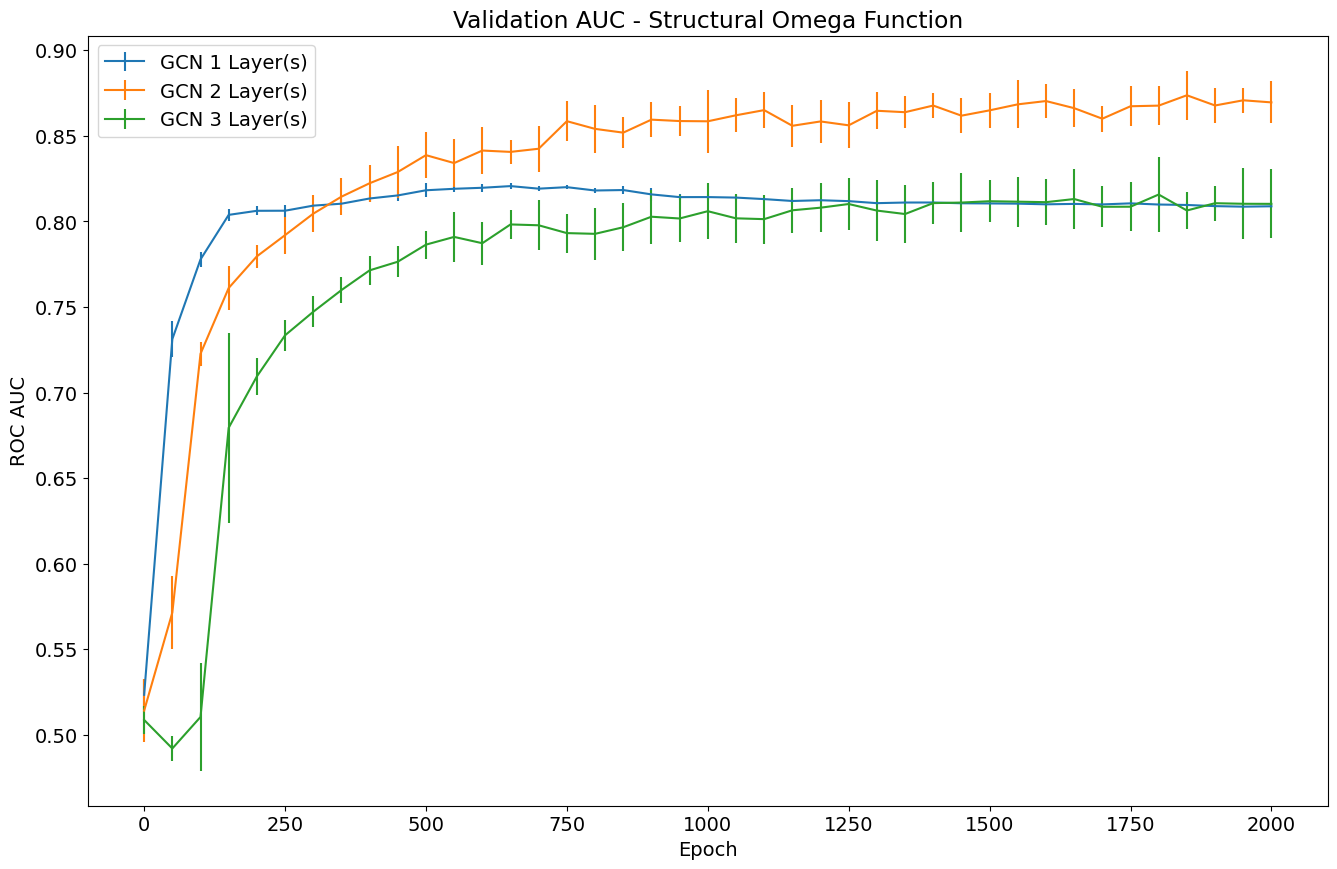

In [25]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation AUC - Structural Omega Function')

for n_layers in mean_auc_val_dict:
    ax1.errorbar(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        yerr=std_auc_val_dict[n_layers],
        ls='-',
        label=f'GCN {n_layers} Layer(s)')

# ax1.set_xlim(-50, 5000)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC AUC')

ax1.legend()

## Score Best model

In [26]:
n_layers_list = range(1, 4)

In [27]:
full_metrics = []
for n_layers_gcn in n_layers_list:
    metrics = StructuralOmegaGCNCosSim.read_metrics(
        dataset='pubmed',
        n_layers_gcn=n_layers_gcn)
    metrics['n_layers_gcn'] = n_layers_gcn
    full_metrics.append(metrics)
full_metrics = pd.concat(full_metrics)

In [28]:
best_model_metrics = full_metrics.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

run                2.000000
epoch           1000.000000
loss_train         0.103891
loss_val           0.318882
loss_test          0.364480
auc_train          0.977976
auc_val            0.901511
auc_test           0.876556
n_layers_gcn       2.000000
Name: 102, dtype: float64

In [29]:
best_model_metrics.to_json('models/structural_omega_grapn_sage_cossim/pubmed/best_model_info.json')